In [1]:
import tensorflow as tf
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import cv2
import glob
import os
import numpy as np
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from matplotlib.pyplot import imshow
%matplotlib inline

from tensorflow.contrib.tensorboard.plugins import projector
import math

import myImageLibrary

from tensorflow.saved_model import simple_save

In [19]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [4]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


In [50]:
def get_classifier_data(image_folder, size = 256, verbose = True, mode = "channels_first",one_hot = False):
    
    folders = os.listdir("images")
    if verbose:
        print("classes: {0}".format(folders))
    input_labels = []
    input_data = []
    label_dict = {}

    for i, folder in enumerate(folders):
        if verbose:
            print("{0}..".format(folder))   
        image_list = myImageLibrary.get_images(os.path.join("images",folder))
        if mode == "channels_first":
            processed_image_list =  [np.around(myImageLibrary.resize_crop(image,size).transpose(2,0,1)/255.0,decimals=12) for image in image_list]
        elif mode == "channels_last":
            processed_image_list =  [np.around(myImageLibrary.resize_crop(image,size)/255.0,decimals=12) for image in image_list]
        else:
            print("invalid mode. pick channels_first or channels_last")
        # processed = normalized, resized and cropped, transposed to "channels first"
        input_labels = input_labels+([i]*len(processed_image_list))
        input_data = input_data+processed_image_list
        label_dict[str(i)] = folder
        
    shape = list(input_data[0].shape)
    shape[:0] = [len(input_data)]
    input_array = np.concatenate(input_data).reshape(shape)
    
    input_labels = np.array(input_labels)
    
    if one_hot:
        input_labels = convert_to_one_hot(np.array(input_labels),len(folders)).T
            
    return input_array, input_labels, label_dict
    

In [51]:
image_folder = "images"
input_images, labels, label_dict = get_classifier_data(image_folder,mode="channels_last",one_hot = True)

classes: ['car', 'plane', 'train']
car..
plane..
train..


In [52]:
print(input_images.shape)
print(labels.shape)
print(label_dict)

(518, 256, 256, 3)

In [56]:
X_train, X_test, Y_train, Y_test = train_test_split(input_images,labels)

In [11]:
X_train.shape

(388, 256, 256, 3)

In [54]:
outputy.shape

(517, 3)

In [12]:
X_train

array([[[[0.4745098 , 0.52156863, 0.52941176],
         [0.47843137, 0.52156863, 0.52941176],
         [0.47843137, 0.51764706, 0.52941176],
         ...,
         [0.60392157, 0.65098039, 0.65882353],
         [0.60784314, 0.65490196, 0.6627451 ],
         [0.61568627, 0.6627451 , 0.67058824]],

        [[0.47843137, 0.5254902 , 0.53333333],
         [0.48235294, 0.52941176, 0.5372549 ],
         [0.49019608, 0.52941176, 0.5372549 ],
         ...,
         [0.61176471, 0.65882353, 0.66666667],
         [0.61176471, 0.65882353, 0.66666667],
         [0.61568627, 0.6627451 , 0.67058824]],

        [[0.49019608, 0.5372549 , 0.54509804],
         [0.49411765, 0.54117647, 0.54901961],
         [0.49803922, 0.54117647, 0.54901961],
         ...,
         [0.60392157, 0.65098039, 0.65882353],
         [0.60392157, 0.65098039, 0.65882353],
         [0.61176471, 0.65882353, 0.6627451 ]],

        ...,

        [[0.12156863, 0.31372549, 0.36862745],
         [0.12156863, 0.31764706, 0.36862745]

In [58]:
def create_sprite(X_train, sprite_path='./', p = 80):
    m = X_train.shape[0]
    #sprite will consist of n rows, n columns of mini-pictures, ordered row-first. Last row can be incomplete
    n = int(math.sqrt(m))+1
    assert n*80 <= 8192
    sprite = np.zeros((n*80,n*80,3))
    i = 0
    j = 0

    for r in range(m):
        
        sprite[i:i+p,j:j+p,:] = cv2.resize(X_train[r,:,:,:],(p,p))
        #cv2.imwrite('debug.jpg',cv2.resize(X_train[r,:,:,:],(p,p)))
        if (r+1)%n != 0:
            j += p
        else:
            j = 0
            i += p
    sprite = (sprite*255).astype(int)
    #weird: showimage requires floats from 0 to 1 (otherwise output is black)
    #but for imwrite, values must be from 0 to 255 (otherwise, outputfile is entirely black)
    #showimage("sprite",sprite)
    cv2.imwrite(os.path.join(sprite_path,'sprite.jpg'),sprite)

In [59]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.placeholder(tf.float32, shape=(None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32, shape=(None,n_y))
    ### END CODE HERE ###
    
    return X, Y

# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                   
        

    with tf.name_scope("conv1"):
        W1 = tf.get_variable("W1",[4,4,3,8],initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    with tf.name_scope("conv2"):
        W2 = tf.get_variable("W2",[2, 2, 8, 16],initializer = tf.contrib.layers.xavier_initializer(seed = 0))


    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [60]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    with tf.name_scope("conv1"):
    # CONV2D: stride of 1, padding 'SAME'
        Z1 = tf.nn.conv2d(X, W1, strides = [1,1,1,1], padding = 'SAME')
        # RELU
        A1 = tf.nn.relu(Z1)
    with tf.name_scope("maxpool1"):
        # MAXPOOL: window 8x8, sride 8, padding 'SAME'
        P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    with tf.name_scope("conv2"):    
        # CONV2D: filters W2, stride 1, padding 'SAME'
        Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
        # RELU
        A2 = tf.nn.relu(Z2)
    with tf.name_scope("maxpool2"):
        # MAXPOOL: window 4x4, stride 4, padding 'SAME'
        P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    with tf.name_scope("dense"):
        # FLATTEN
        P3 = tf.contrib.layers.flatten(P2)
        # FULLY-CONNECTED without non-linear activation function (not not call softmax).
        # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
        Z3 = tf.contrib.layers.fully_connected(P3, 3, activation_fn = None)
    

    return Z3, P2

In [61]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    ### END CODE HERE ###
    
    return cost

In [133]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True,tensorboardpath=None,saved_model_path = None):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3, P2 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)

    if tensorboardpath is not None:
        summary_cost = tf.summary.scalar('cost',cost)
        summary_output = tf.summary.histogram('output',Z3)
        merged_summary = tf.summary.merge_all()
        
        summary_images = tf.summary.image('training_images',X)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    #optimizer is an 'Operation' that updates the variables
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph    
    with tf.Session() as sess:
        
        

        # Run the initialization
        sess.run(init)
        
        
        if tensorboardpath is not None:
            filewriter_train = tf.summary.FileWriter(os.path.join(tensorboardpath,'train'),sess.graph)
            filewriter_test = tf.summary.FileWriter(os.path.join(tensorboardpath,'test'),sess.graph)
            #filewriter_embedding = tf.summary.FileWriter('./tensorboard_embedding/',sess.graph)
            
            image_summary = sess.run(summary_images,feed_dict={X: X_train, Y: Y_train})
            filewriter_train.add_summary(image_summary)
            saver = tf.train.Saver()

        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for i,minibatch in enumerate(minibatches):

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                
                if tensorboardpath is not None:
                    summary,_ , temp_cost = sess.run([summary_cost,optimizer,cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                    filewriter_train.add_summary(summary,epoch*num_minibatches+i)
                else:
                    _ , temp_cost = sess.run([optimizer,cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                
                #evaluate train cost every MINIBATCH and display in tensorboard
                #if tensorboardpath is not None:
                #    filewriter_train.add_summary(summary,epoch*num_minibatches+i)
                
                
            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
                
            #evaluate test cost and test output histogram every EPOCH and display in tensorboard
            if tensorboardpath is not None:           
                summary = sess.run(merged_summary, feed_dict={X: X_test, Y: Y_test})
                filewriter_test.add_summary(summary,(epoch+1)*num_minibatches)
        
                print("setting up tensorboard...")
                LOG_DIR = os.path.join(tensorboardpath,"test")
        
                z3 = sess.run(Z3,feed_dict={X: X_test, Y: Y_test})
                embedding_var = tf.Variable(z3,  name='embedding')
                #embedding_var is initialized with z3 values. Running this initialization in line below.
                sess.run(embedding_var.initializer)
                summary_writer = tf.summary.FileWriter(LOG_DIR)
        
                config = projector.ProjectorConfig()
                embedding = config.embeddings.add()     
                embedding.tensor_name = embedding_var.name
        
                print("creating sprite...")
                p=80 #thumbnail pixel size in sprite image.
                create_sprite(X_test,sprite_path=LOG_DIR,p=p)        
                #the path below must be relative to the directory of the filewriter. It is for example correct, if 
                #the path is sprite.jpg in the configfile, and configfile and sprite.jpg are in same folder
                embedding.sprite.image_path = "sprite.jpg"
                print(embedding.sprite.image_path)       
                #Specify the width and height of a single thumbnail.
                embedding.sprite.single_image_dim.extend([p, p])

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        #t.eval(feed_dict=None, session=None) is a shortcut for tf.get_default_session().run(t)
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        
        if tensorboardpath is not None:
            print("creating metadata for embedding visualisation...")
            digit_to_label = {"0":"car","1":"plane","2":"train"}
            with open(os.path.join(LOG_DIR,"metadata.tsv"), 'w') as f:
                f.write("Index\tLabel\n")
                print(z3.shape)
                print(np.argmax(z3,axis=1).astype(int).shape)
                for index, digit in enumerate(list(np.argmax(z3,axis=1).astype(int))):
                    f.write("{0}\t{1}\n".format(index,digit_to_label[str(digit)])) 
            embedding.metadata_path = "metadata.tsv"

            projector.visualize_embeddings(filewriter_test,config)
            #projector.visualize_embeddings(summary_writer,config)
            saver = tf.train.Saver([embedding_var])
            saver.save(sess,os.path.join(LOG_DIR,"model.ckpt"))

        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        if saved_model_path is not None:
            simple_save(sess,saved_model_path,inputs={"X":X},outputs={"Z3":Z3})
                
        return train_accuracy, test_accuracy, parameters

Documentation for tensorboard add_summary: https://www.tensorflow.org/versions/r1.5/api_docs/python/tf/summary/FileWriter#add_summary

**You can pass the result of evaluating any SUMMARY op, using tf.Session.run or tf.Tensor.eval, to this function**

Thus, you pass the result of evaluating a SUMMARY OPERATION, not just the result of evaluating an ordinary tensor. Type of summary variable is *bytes*, which can be passed to filewriter. Merging all can be handy, tf.summary.merge_all() is also a summary op.

In [134]:
run_id

46

# conclusions

High variance: train accuracy 100%, test accuracy approx. 80%

Randomness in results of test accuracy: multiple percentage points! How is this possible??


Cost after epoch 0: 1.363143
Cost after epoch 5: 0.872636
Train Accuracy: 0.6958763
Test Accuracy: 0.5846154


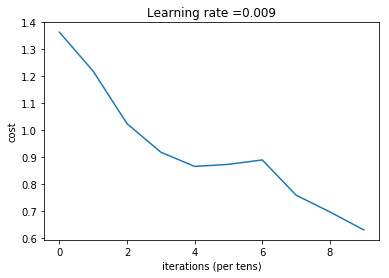

INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: savedModel\saved_model.pb


ValueError: not enough values to unpack (expected 4, got 3)

In [135]:
#with tensorboard:
#run_id += 1
#_, _, parameters, sess = model(X_train, Y_train, X_test, Y_test,num_epochs=10,tensorboardpath="./tensorboard/{0}/".format(run_id))

EXPORT_DIR = "savedModel"

#without tensorboard, but with saving to SavedModel for serving
_, _, parameters, sess = model(X_train, Y_train, X_test, Y_test,num_epochs=10,saved_model_path = EXPORT_DIR)

## vreemde error hierboven?

# Convert to SavedModel

Model was saved to SavedModel in EXPORT_DIR (by the function which creates the model.)

savedModel was created with simple_save 
https://www.tensorflow.org/api_docs/python/tf/saved_model/simple_save
Uses the tag tag_constants.SERVING. Supports the predict API. For Classify, Regress, or MultiInference APIs, use tf.Estimator or the lower level SavedModel API's. 

Below, we use tensorflow.contrib.predictor

# Load SavedModel for serving

In [136]:
from tensorflow.contrib import predictor
from tensorflow.saved_model import tag_constants

In [148]:
size = 256
test_image = cv2.imread("images/car/img_2.jpg")
test_image = np.expand_dims(myImageLibrary.resize_crop(test_image,size),axis=0)

In [149]:
predict_fn = predictor.from_saved_model(EXPORT_DIR)
prediction = predict_fn({"X":test_image})

INFO:tensorflow:Restoring parameters from savedModel\variables\variables


In [150]:
prediction

{'Z3': array([[ -79.092735, -388.82263 ,   26.819468]], dtype=float32)}

In [151]:
predicted_label = label_dict[str(np.argmax(prediction["Z3"]))]
predicted_label

'train'